In [1]:
import numpy as np
#import gym
import sys
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib


%matplotlib inline
#fig, ax = plt.subplots(figsize=(20, 10)) 
#fig, ax = plt.subplots(figsize=(18, 2))
#ax.imshow(random.rand(8, 90), interpolation='nearest')
#tight_layout()

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(20,20)

sys.path.append('../src')
sys.path.append('../src/envs')
sys.path.append('../src/game_generator')
sys.path.append('../src/agents')
sys.path.append('../src/utils')

def showim(buffer):
    fig, ax = plt.subplots(figsize=(9, 9))
    #ax.imshow(random.rand(8, 90), interpolation='nearest')
    ax.imshow(buffer,interpolation='nearest',aspect='auto')

In [2]:

from robot_reboot_extractor import RobotRebootExtractor
from ricochet_env import RicochetEnv
from agent_dqn import DQNAgent
from simulation import Experiment
from utils import helper

Using TensorFlow backend.


In [3]:
agent , env = helper.prepare_game('game1.png')

<IPython.core.display.Javascript object>


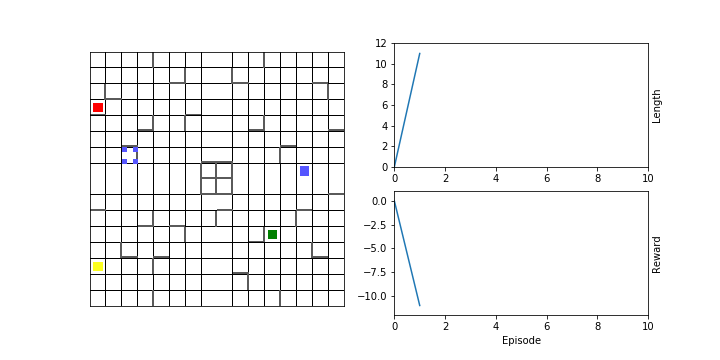

too many steps. Stopped


In [4]:
interactive = True
%matplotlib nbagg

experiment = Experiment(env, agent)

experiment.run_agent( max_number_of_episodes=1, max_number_of_steps=10, interactive = True, display_frequency=1)

In [3]:
im = Image.open( '../games/game1.png').convert('RGB')

In [4]:
im.size

(642, 642)

In [5]:
agent = DQNAgent(8 , 4)

In [6]:
rre = RobotRebootExtractor(im)

In [7]:
env = RicochetEnv(rre)
env.reset()

[[1, 2], [13, 0], [11, 11], [7, 13]]

In [9]:
buffer = env.render(mode='rgb_array')

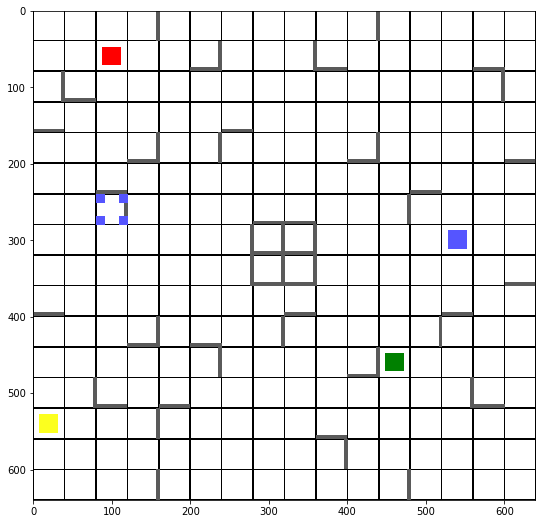

In [9]:
showim(buffer)

In [11]:
env.step( env.encode_action( 'r' , 'N') )

([[0, 2], [13, 0], [11, 11], [7, 13]], -1, False, '')

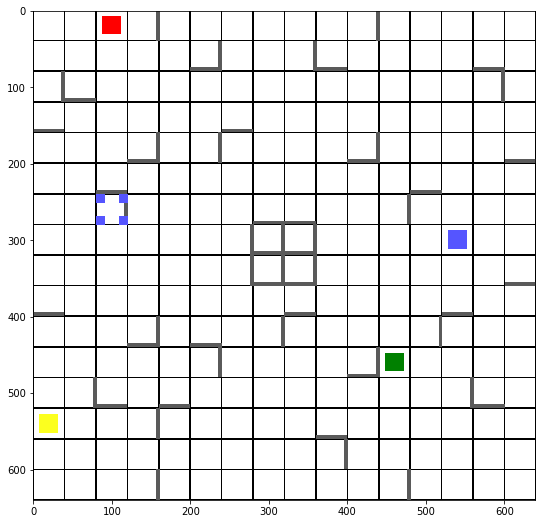

In [12]:
showim( buffer = env.render() )

([[0, 2], [13, 0], [11, 11], [13, 9]], -1, False, '')

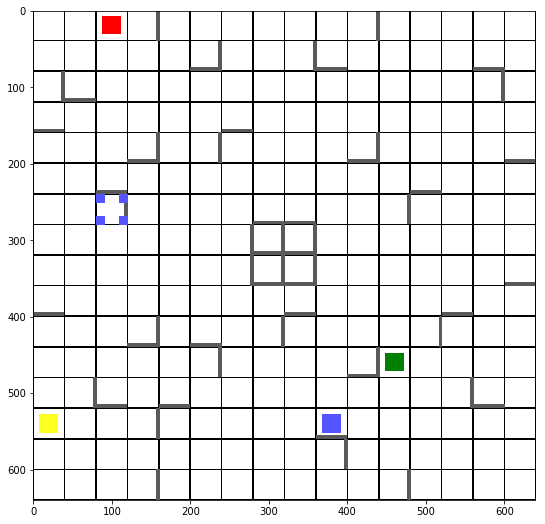

In [14]:
state = env.step( env.encode_action( 'b' , 'S') )
showim( buffer = env.render() )
state

In [8]:
rre.goal

(6, 2, 'b')

In [ ]:
%load_ext autoreload

In [17]:

%autoreload 2

[[1, 2], [13, 0], [11, 11], [7, 13]]


In [5]:
def prepare_game(img_file='game1.png'):
    im = Image.open( '../games/' + img_file).convert('RGB')
    agent = DQNAgent(8 , 4)
    rre = RobotRebootExtractor(im)
    env = RicochetEnv(rre)
    
    return agent , env

In [6]:
agent , env = prepare_game()

<IPython.core.display.Javascript object>


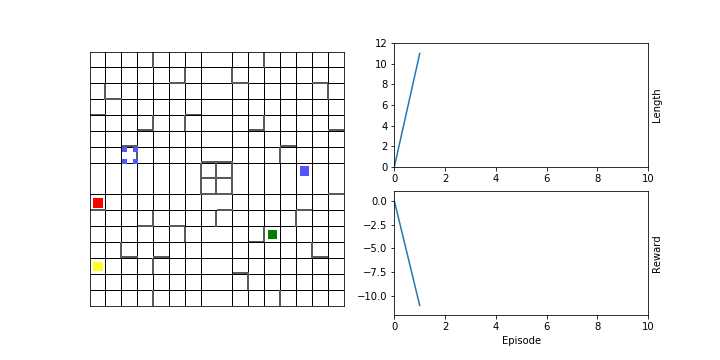

too many steps. Stopped


In [7]:
interactive = True
%matplotlib nbagg

experiment = Experiment(env, agent)

experiment.run_agent( max_number_of_episodes=1, max_number_of_steps=10, interactive = True, display_frequency=1)